In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rlxai import ImageXAI , A2C

In [3]:

import gym
import numpy as np
import matplotlib.pyplot as plt
from torch import nn 
from torchvision import models
import torch 
env = gym.make("Breakout-v0")

/opt/conda/envs/xai/lib/python3.8/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()
A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


In [4]:

actor = models.resnet18(pretrained=True)
actor.conv1 =nn.Conv2d(1,64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
actor.fc = nn.Linear(512, env.action_space.n)

critic = models.resnet18(pretrained=True)
critic.conv1 =nn.Conv2d(1,64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
critic.fc = nn.Linear(512, 1)

A2C_MODEL = A2C(actor=actor,critic=critic,lr=1e-3)
A2C_MODEL.load_model("./")
model=A2C_MODEL.actor

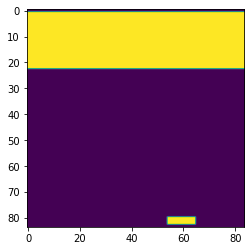

In [5]:
import cv2 


def img_crop(img_arr) :
    return img_arr[55:-15,15:-15,:]
def rgb2gray(rgb):
    image_data = cv2.cvtColor(cv2.resize(rgb, (84, 84)), cv2.COLOR_BGR2GRAY)
    image_data[image_data > 0] = 255
    image_data = np.reshape(image_data,(84, 84, 1))
    return image_data
def totensor(img_arr) :
    return torch.FloatTensor(img_arr.transpose((2, 0, 1))).unsqueeze(dim=0)

img_arr = env.render(mode="rgb_array")
plt.imshow(rgb2gray(img_crop(img_arr)))

In [6]:
img_arr = env.render(mode="rgb_array")
iteration = 0 
env.reset()
while True :
    img_arr,r,done,info = env.step(env.action_space.sample())
    if iteration == 100 :
        break 
    else :
        iteration += 1 

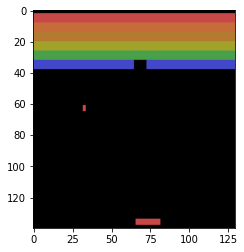

In [7]:
plt.imshow(img_crop(img_arr))
plt.show()

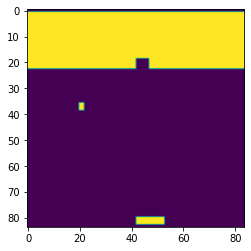

In [8]:
plt.imshow( rgb2gray(img_crop(img_arr)))
plt.show()

In [16]:

def data_transform(x) :
    # x = img_crop(x)
    # x = rgb2gray(x)
    x = totensor(x)
    return x

target2idx = {i:idx  for idx , i in enumerate(env.unwrapped.get_action_meanings())}

xai = ImageXAI(model ,  target2idx , data_transform)

In [17]:
rgb2gray(img_crop(img_arr)).shape

(84, 84, 1)

In [22]:
xai(rgb2gray(img_crop(img_arr)) , "0")

run...
classify...
run for xai...
Approximation delta:  tensor([0.0288], dtype=torch.float64)


In [23]:
folder_dir = "./result"
from pathlib import Path
ResultDir = Path(folder_dir)
ResultDir.mkdir(exist_ok=True)

In [24]:
xai.showResult(save_path=ResultDir.joinpath("./Result.png"))

{0: '0', 1: '1', 2: '2', 3: '3'}
probability :  tensor([[1.6103e-05, 4.4897e-04, 9.9946e-01, 7.9566e-05]],
       grad_fn=<SoftmaxBackward>)


In [25]:
xai.show_integrated_gradients(save_folder=ResultDir)
xai.plot_Occlusion(strides=(1, 8, 8), sliding_window_shapes=(1, 15, 15),save_path=ResultDir.joinpath("./Occlusion.png"))
xai.plot_InputXGradient(target=1, save_path=ResultDir.joinpath("./InputXGradeint.png"))
xai.plot_InputXGradient_all_target(save_path=ResultDir.joinpath("./InputXGradeint_ALL.png"))
xai.plot_GuidedBackprop_all_target(n_row=2, save_path=ResultDir.joinpath("./GuideBackprop.png"))
xai.plot_IntegratedGradients_Black(save_path=ResultDir.joinpath("./IntegratedGradients_Black.png"))

Predicted: 2  Probability: tensor([[1.6103e-05, 4.4897e-04, 9.9946e-01, 7.9566e-05]],
       grad_fn=<SoftmaxBackward>)
step1
step2
step3
step4


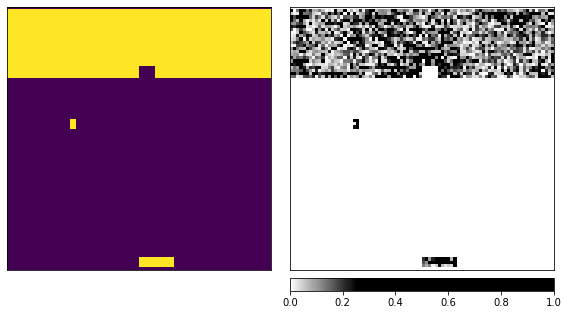

Lime attribution: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


In [26]:
xai.plot_IntegratedGradients_NoiseTunnel(save_path=ResultDir.joinpath("./IntegratedGradients_NoiseTunnel.png"))
xai.plot_GradientShap(save_path=ResultDir.joinpath("./GradientShap.png"))
xai.plot_LRLIME(save_path=ResultDir.joinpath("./LRLIME.png"))